# Dataset Part

### Install dependencies

In [1]:
# !pip3 install PyQt5
# !pip3 install ipywidgets
# !pip3 install scikit-learn
# !pip3 install tensorflow_addons
# !pip3 install bs4
# !pip3 install fake_useragent
# !pip3 install pytest

In [2]:
!pip install fake_useragent
!pip install imutils
!pip install gdown
!pip install kaggle --user
# !pip install tensorflowjs

     |████████████████████████████████| 50 kB 3.1 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=380d44d4fe1d83ad74f74af06485f53dc2a19618ce9d2ee84b23d2f12f7416e0
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


### import main dependencies

In [3]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import hashlib
import sys
import random
import os
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from fake_useragent import UserAgent
from matplotlib.widgets import Button
import datetime
from tensorflow.keras import layers
import pathlib
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from PIL import Image
import scipy
import numpy as np
import argparse
import imutils
import time
import cv2
import requests
from IPython.display import clear_output
from io import BytesIO
from IPython.display import display, clear_output
#from ipywidgets import interact
#import ipywidgets as widgets
from PIL import ImageFilter
from bs4 import *
import uuid
from IPython.display import display, Markdown, clear_output, FileLink, FileLinks
from IPython.display import Image as IImage 
import ipywidgets as widgets
from PIL import Image
import pandas as pd
import gdown
from random import randrange
import ipywidgets as widgets
import shutil
from io import BytesIO
import json
import time
import mimetypes

### Defining main variables

In [4]:
!ls /kaggle/input/holipics-lite/holipics-dataset/images

ls: cannot access '/kaggle/input/holipics-lite/holipics-dataset/images': No such file or directory


In [5]:
BUILD_NEW_DATASET = True
REDUCE_DATASET_IMAGES = False
USE_DATA_RELATIONSHIP = False
DOWNLOAD_ADDITIONAL_IMAGES = False
DEPLOY_DATASET_TO_SERVER = True
USE_UPDATED_DATASET = True
BASE_PATH = "/kaggle/input/nsfw-content-moderation/"
DATASET_PATH = BASE_PATH+"images"
STORE_PATH="save"
DATASET_COPY_PATH = STORE_PATH+"/images_backup"
TEST_SET_PATH= "test"
# DATASET_DUMP_PATH = BASE_PATH+("/images_backup_lite" if BUILD_NEW_DATASET else "/images_backup")  
DATASET_DUMP_PATH = "images_backup_lite/images_backup_lite" #if"images_backup"
CSV_DATASET_PATH = "image_dataset.csv"
IMAGE_RES = 224
MODEL_PATH = "models"
SAVED_MODEL_PATH = STORE_PATH + "/" + MODEL_PATH
UNWATED_PATHS = []
MAX_IMAGE_PER_CLASS = 2000 #3000
MAX_IMAGE_PER_SEVERE_CLASS = 3000 #1500
SEVERE_CLASSES = ["general_not_nsfw_not_suggestive"]
DATASET_NAME = "isralkaramoko/holipics-lite"
DATASET_URL = "https://www.kaggle.com/"+DATASET_NAME
DATASET_ZIP = "holipics-lite.zip"
DATASET_DOWNLOAD_URL = "http://188.166.126.190:83/filebrowser/api/public/dl/Krp4tZMY"
ASSETS_DOWNLOAD_URL = "http://188.166.126.190:83/filebrowser/api/public/dl/rQ6jKE2f"
ASSETS_PATH="assets"

### Kaggle api

In [6]:
credentials = {"username":"jamesdame","key":"157e2681cd07fe2460010b340d5a7504"}
kaggle_key_store='kaggle.json'
with open(kaggle_key_store, 'w', encoding='utf-8') as f:
    json.dump(credentials, f, ensure_ascii=False, indent=4)

!rm -rf /root/.kaggle     # when I created the folder, it says the file or dir already exits
!mkdir /root/.kaggle        # successful
!mv kaggle.json /root/.kaggle/kaggle.json    # not sure if I have to use full destination path, I previously only used /root/.kaggle and it failed. Don't have time to validate this thought.
!ls /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

/root/.kaggle/kaggle.json


### main functions

In [7]:
def preview_images_from_directory(path=DATASET_PATH, group=True):
    dimensions=(IMAGE_RES, IMAGE_RES)
    data_dir = path
    clean_up_data_dir(data_dir)
    images_path = []
    
    if(group):
        data_sub_directories = os.listdir(data_dir)
        for data_sub_directory in data_sub_directories:
#             print("found {0} for class {1}".format(len(os.listdir(os.path.join(data_dir, data_sub_directory))), data_sub_directory))
            for current_dir in os.listdir(os.path.join(data_dir, data_sub_directory)):
                images_path.append(os.path.join(data_sub_directory, current_dir))
    else:
        try:
            for current_dir in os.listdir(data_dir):
                images_path.append(os.path.join(data_dir, current_dir))
        except Exception as wrong:
            pass

    if not group:
        data_dir = "."
        
    current = 0        
    output = widgets.Output()
    next_button = widgets.Button(description='Next')
    prev_button = widgets.Button(description='Prev')
    display_current_button = widgets.Button(description='Current')
    current_index_text = widgets.Textarea(
        value=str(current),
        placeholder='current index goes here',
        description='index',
        disabled=False
    )
    
    display(current_index_text, display_current_button, prev_button, next_button, output)
    
    def default_action():
        global current
        with output:
            clear_output()
            print("{0}: {1}/{2}".format(images_path[current].split("/")[0], current+1, len(images_path)))
            image = cv2.imread(os.path.join(data_dir, images_path[current]))
            # imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
            imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
            
            current_image = Image.fromarray(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA))
            display(current_image)
            
    def on_next_button_clicked(_):
        global current
        if current+2 > len(images_path):
            return None
        current+=1
        default_action()


    def on_prev_button_clicked(_):
        global current
        if current-1 < 0:
            return None
        current-=1
        default_action()
        
        
    def on_current_index_change(_):
        update_index_change(current_index_text.value)

    def update_index_change(indexString):
        global current
        try:
            current = int(indexString)
            default_action()
        except Exception as wrong:
            pass

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    display_current_button.on_click(on_current_index_change)
    current_index_text.on_displayed(update_index_change(str(current)))
    
    
    
    
def order_images(main_dir, start=-1, end=-1, figsize=(30, 30), dimensions=(IMAGE_RES, IMAGE_RES)):
    %matplotlib inline
    from IPython.display import display, Markdown, clear_output
    from IPython.display import Image as IImage 
    import ipywidgets as widgets

    current  =  0
    del_dir = os.path.join(main_dir, ".ipynb_checkpoints")
    !rm -r $del_dir
    if start == -1 and end == -1:
        images_path = os.listdir(main_dir)
    elif start != -1 and end == -1:
        images_path = os.listdir(main_dir)[start:len(os.listdir(main_dir))]
    elif start == -1 and end != -1:
        images_path = os.listdir(main_dir)[0:end]
    else:
        images_path = os.listdir(main_dir)
        
    next_button = widgets.Button(description='Next')
    prev_button = widgets.Button(description='Prev')
    move_button = widgets.Button(description='Move')
    class_names = os.listdir(DATASET_PATH)
    moving_paths = []

    path_selector = widgets.SelectMultiple(
        options=class_names,
        value=[],
        description='Fruits',
        disabled=False
    )
    output = widgets.Output()
    display(prev_button, next_button, output, path_selector, move_button)

    def on_next_button_clicked(_):
        global current
        if current+2 > len(images_path):
            return None
        moving_paths = []
        with output:
            current+=1
            clear_output()
            print("{0}/{1}".format(current+1, len(images_path)))
            pil_img = IImage(filename=os.path.join(main_dir, images_path[current]), width = dimensions[0], height=dimensions[1])
            display(pil_img)

    def on_prev_button_clicked(_):
        global current
        if current-1 < 0:
            return None
        moving_paths = []
        with output:
            current-=1
            clear_output()
            print("{0}/{1}".format(current+1, len(images_path)))
            pil_img = IImage(filename=os.path.join(main_dir, images_path[current]), width = dimensions[0], height=dimensions[1])
            display(pil_img)
    def on_move_button_clicked(_):
        with output:
            print(path_selector.value)
            for current_path in path_selector.value:
                os.system("cp '{0}' '{1}'".format(os.path.join(main_dir, DATASET_PATH+"/"+images_path[current]), current_path))

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    move_button.on_click(on_move_button_clicked)


In [8]:
dump_dir = DATASET_DUMP_PATH
def clean_up_data_dir(data_dir):
    data_sub_directories = os.listdir(data_dir)
    for data_sub_directory in data_sub_directories:
        path_to_delete = os.path.join(data_dir, data_sub_directory, ".*")
        !rm -r $path_to_delete

    !rm -r $data_dir/.ipynb_checkpoints
    !rm -r $data_dir/.DS_Store

# CREATE FOLDER
def folder_create(images, given_folder_name=""):
    try:
        folder_name = os.path.join(dump_dir, input("Enter Folder Name:- ") if given_folder_name == "" else given_folder_name)
        # folder creation
        os.mkdir(folder_name)
 
    # if folder exists with that name, ask another name
    except:
        print("Folder Exist with that name!")
        folder_create()
 
    # image downloading start
    download_images(images, folder_name)
 
 
# DOWNLOAD ALL IMAGES FROM THAT URL
def download_images(images, folder_name):
   
    # initial count is zero
    count = 0
 
    # print total images found in URL
    print(f"Total {len(images)} Image Found!")
 
    # checking if images is not zero
    if len(images) != 0:
        for i, image in enumerate(images):
            # From image tag ,Fetch image Source URL
 
                        # 1.data-srcset
                        # 2.data-src
                        # 3.data-fallback-src
                        # 4.src
 
            # Here we will use exception handling
 
            # first we will search for "data-srcset" in img tag
            try:
                # In image tag ,searching for "data-srcset"
                image_link = image["src"]
                 
            # then we will search for "data-src" in img
            # tag and so on..
            except:
                try:
                    # In image tag ,searching for "data-src"
                    image_link = image["data-src"]
                except:
                    try:
                        # In image tag ,searching for "data-fallback-src"
                        image_link = image["data-fallback-src"]
                    except:
                        try:
                            # In image tag ,searching for "src"
                            image_link = image["data-srcset"]
 
                        # if no Source URL found
                        except:
                            pass
 
            # After getting Image Source URL
            # We will try to get the content of image
            try:
                print("Downloading image: {0}/{1}; store => {2}".format(count, len(images), folder_name))
                r = requests.get(image_link).content
                try:
 
                    # possibility of decode
                    r = str(r, 'utf-8')
                except UnicodeDecodeError:
 
                    # After checking above condition, Image Download start
                    with open(f"{folder_name}/images{i+1}.jpg", "wb+") as f:
                        f.write(r)
 
                    # counting number of image downloaded
                    count += 1
            except:
                pass
 
        # There might be possible, that all
        # images not download
        # if all images download
        if count == len(images):
            print("All Images Downloaded!")
             
        # if all images not download
        else:
            print(f"Total {count} Images Downloaded Out of {len(images)}")
 
# MAIN FUNCTION START
def download_images_from_url(url, given_folder_name=""):
    if url == None or ( url.find("http") == -1 and url.find("www") == -1 ):
        return
    # content of URL
    ua = UserAgent()

    # Get list of user agents.


    # headers = {'User-Agent': ua.random}
    # r = requests.get(url, headers=headers)
    r = requests.get(url)
    print(url)
    print(r)
    # Parse HTML Code
    soup = BeautifulSoup(r.text, 'html.parser')
 
    # find all images in URL
    images = soup.findAll('img')
 
    # Call folder create function
    folder_create(images, given_folder_name)

def remove_duplicates(dir, include_src=False):
    hashMap = {}
    # List to store deleted files
    deletedFiles = []
    source_dup_file = []
    filelist = os.listdir(dir)
    for f in filelist:
        f = os.path.join(dir, f)
        key = hashFile(f)
        # If key already exists, it deletes the file
        if key in hashMap.keys():
            deletedFiles.append(f)
            if include_src:
                try:
                    index = source_dup_file.index(key)
                except Exception as e:
                    source_dup_file.append(key)
            os.remove(f)
        else:
            hashMap[key] = f
    if include_src:
        for key in source_dup_file:
            deletedFiles.append(f)
            os.remove(hashMap[key])
            
    if len(deletedFiles) != 0:  
        for deleted_file in deletedFiles:
            print('Deleted Files {0}'.format(deleted_file))
        print("total deleted => {}".format(len(deletedFiles)))
    else:
        print('No duplicate files found')
    

def remove_small_files(dir, min_size=5):
    for root, _, files in os.walk(dir):
        for f in files:
            fullpath = os.path.join(root, f)
            try:
                if os.path.getsize(fullpath) < min_size * 1024:   #set file size in kb
                    print(fullpath)
                    os.remove(fullpath)
            except Exception as e:
                print("Error" + fullpath)

def rename_all_files(dir):
    for root, _, files in os.walk(dir):
        for f in files:
            fullpath = os.path.join(root, f)
            try:
                filename, file_extension = os.path.splitext(fullpath)
                newname = str(uuid.uuid1())+"."+file_extension
                os.rename(fullpath, os.path.join(dir, newname))
           
            except Exception as e:
                print(e)
                print("Error" + fullpath)
                
def delete_unreadable_images(dir):
    for root, _, files in os.walk(dir):
        for f in files:
            fullpath = os.path.join(root, f)
            try:
                img = Image.open(fullpath)
            except Exception as e:
                os.system("rm {}".format(fullpath))
                print("Removing => " + fullpath)

def remove_randomly_dir_files(dir, limit=2, percentage=0):
    files = os.listdir(dir)

    if(percentage != 0):
        limit = int((percentage * len(files)) / 100)

    print("Total files found : {}".format(len(files)))
    deleted_indexes = [-1]
    count = 0
    if limit >= len(files):
        print("limit >= len(files)")
        return 

    for i in range(0, limit):
        if len(deleted_indexes) > limit:
            print("len(deleted_index) > limit")
            break

        random_index = -1

        while ( random_index in deleted_indexes) == True:
            random_index = random.randint(0, len(files)-1)

        deleted_indexes.append(random_index)
        count+=1

        print("deleting {0}/{1}; index => {2}".format(i+1, limit, random_index))
        os.remove(os.path.join(dir, files[random_index]))

    print("Total deleted files {}".format(count))
    print("Total files remaining {}".format(len(os.listdir(dir))))
    
def hashFile(filename):
    # For large files, if we read it all together it can lead to memory overflow, So we take a blocksize to read at a time
    BLOCKSIZE = 65536
    hasher = hashlib.md5()
    with open(filename, 'rb') as file:
        # Reads the particular blocksize from file
        buf = file.read(BLOCKSIZE)
        while(len(buf) > 0):
            hasher.update(buf)
            buf = file.read(BLOCKSIZE)
    return hasher.hexdigest()

def predict_at_random_download(base_url="https://picsum.photos/{0}/{0}".format(IMAGE_RES), store=DATASET_PATH, group=True):
    selected_class = class_names[0]
    selected_image = []
    again_button = widgets.Button(description='Again')
    download_button = widgets.Button(description='Download')
    class_selector = widgets.Dropdown(
        options=class_names,
        value=selected_class,
        description='Select a class',
        disabled=False,
    )

    output = widgets.Output()
    display(again_button, class_selector, download_button, output)

    def on_again_button_clicked(_):
        global selected_image
        with output:
            clear_output()
            to_print, image = predict_single_image_from_url(base_url)
            selected_image = image
            print(to_print)
            display(image)
            
    def on_download_button_clicked(_):
        global selected_image
        global selected_class
        with output:
            try:
                if group:  
                    export_path = "{}.jpg".format(os.path.join(store, selected_class, str(uuid.uuid1())))
                else:
                    export_path = "{}.jpg".format(os.path.join(store, str(uuid.uuid1())))
                print("selected class => ", selected_class)
                print("export path => ", export_path)
                selected_image.save(export_path)
                local_file = FileLink(export_path, result_html_prefix="Click here to download model: ")
                display(local_file)
            except Exception as wrong:
                print("error while moving file to =>", selected_class)
                print(wrong)
    def on_class_change(change):
        global selected_class
        try:
            selected_class = class_names[change["new"]["index"]]
        except Exception as wrong:
            pass
        

    with output:
        clear_output()
        to_print, image = predict_single_image_from_url(base_url)
        selected_image = image
        print(to_print)
        display(image)
    
    again_button.on_click(on_again_button_clicked)
    download_button.on_click(on_download_button_clicked)
    class_selector.observe(on_class_change)
    
def download_collection_from_unsplash(collection_id = "500522", selected_class="", store=DATASET_COPY_PATH, group=True, perPage=10, page=1, image_width=IMAGE_RES, image_height=IMAGE_RES, fit="crop", download_link=False):
    api_key = '3E1O5xqWI-Opz3W81XdmIvZwPJ2qFTHggE5YUxZysDg'
    url = "https://api.unsplash.com/collections/{0}/photos?page={1}&per_page={2}".format(collection_id, page, perPage)
    # ua = UserAgent()
    # headers = {'User-Agent': ua.random, 'Authorization': "Client-ID {}".format(api_key)}
    headers = {
        'Authorization': "Client-ID {}".format(api_key),
        }
    images = []
    count = 0
    total = 0
    total_pages = 1
    current_page = page
    
    try:
        response = requests.get(url.format(collection_id, current_page, perPage), headers=headers)
        total = int(response.headers['X-Total'])
        
        while(total_pages * perPage < total):
            total_pages+=1
    except Exception as wrong:
        print("count error")
        print(wrong)
        
    while current_page <= total_pages:
        print("processing page ", current_page, "/", total_pages)
        try:
            response = requests.get(url.format(collection_id, current_page, perPage), headers=headers)
            response_json = response.json()
            for image_data in response_json:
                print("downloading image ",count+1, "/", total)
                try:
                    if group:  
                        export_path = "{}.jpg".format(os.path.join(store, selected_class, str(uuid.uuid1())))
                    else:
                        export_path = "{}.jpg".format(os.path.join(store, str(uuid.uuid1())))
                    image_response = requests.get(image_data["urls"]["raw"]+"&w={0}&h={1}&fit={2}".format(image_width, image_height, fit))
                    #raw,full, regular, small, thumb, small_s3    
                    image = np.asarray(bytearray(image_response.content), dtype="uint8")
                    imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
                    imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)
                    cv2.imwrite(export_path, imageBGR)
                    if download_link:
                        local_file = FileLink(export_path, result_html_prefix="Click here to download: ")
                        display(local_file)            
                except Exception as wrong:
                    print(wrong)
                    print("error while downloading image")
                count+=1
        except Exception as wrong:
            print("error while loading collections photos")
        current_page+=1

### Download dataset

In [9]:
# if USE_UPDATED_DATASET:
#     dwd_url = DATASET_DOWNLOAD_URL
#     splitted = dwd_url.split("/")
#     dwd_file_name = splitted[len(splitted)-1]

#     !wget $dwd_url
#     !mv $dwd_file_name archive.zip
#     import zipfile
#     with zipfile.ZipFile("archive.zip","r") as zip_ref:
#         zip_ref.extractall("./")
# else:
#     !kaggle datasets download -d $DATASET_NAME
#     !unzip -n $DATASET_ZIP

### Download Assets

In [10]:
# if USE_UPDATED_DATASET:
#     dwd_url = ASSETS_DOWNLOAD_URL
#     splitted = dwd_url.split("/")
#     dwd_file_name = splitted[len(splitted)-1]

#     !wget $dwd_url
#     !mv $dwd_file_name archive.zip
#     import zipfile
#     with zipfile.ZipFile("archive.zip","r") as zip_ref:
#         zip_ref.extractall("./")

### creating directory architecture

In [11]:
!mkdir $MODEL_PATH
!mkdir $MODEL_PATH/epoch
!mkdir $DATASET_PATH
!mkdir $TEST_SET_PATH
!mkdir $STORE_PATH
!mkdir $DATASET_COPY_PATH
!mkdir $SAVED_MODEL_PATH
!mkdir $ASSETS_PATH

mkdir: cannot create directory ‘/kaggle/input/nsfw-content-moderation/images’: Read-only file system


### Moving files downloaded to dataset

In [12]:
# for path in os.listdir(DATASET_PATH):
#     cmd = "rm -r {}/".format(os.path.join(DATASET_PATH, path))
#     print("deleting => {}".format(path))
#     os.system(cmd)
    
# os.system("cp -r {1}/* {0}/ ".format(DATASET_PATH, DATASET_DUMP_PATH))

### Delete unwanted paths

In [13]:
# for path in UNWATED_PATHS:
#     cmd = "rm -r {}/".format(os.path.join(DATASET_PATH, path))
#     print("deleting => {}".format(path))
#     os.system(cmd)

### resolving dataset relashionships

In [14]:
DATA_RELATIONSHIP = [
    {
        "output": "male_sexy",
        "classes": ["male_underwear", "male_shirtless"]
    },
    {
        "output": "female_sexy",
        "classes": ["female_swimwear", "female_underwear"]
    }
]

cmds = [] #=> {"label": "", "cmd"}
if USE_DATA_RELATIONSHIP:
    for data_relationshp in DATA_RELATIONSHIP:
        cmds.append({
            "label": "creating output dir => {}".format(data_relationshp["output"]),
            "cmd": "mkdir {0}/{1}".format(DATASET_PATH, data_relationshp["output"])
        })

        for current_class in data_relationshp["classes"]:
            cmds.append({
                "label": "copying images from {0} to {1}".format(current_class, data_relationshp["output"]),
                "cmd": "cp -r {0}/{1}/* {0}/{2}".format(DATASET_PATH, current_class, data_relationshp["output"])
            })

            cmds.append({
                "label": "removing {}".format(current_class),
                "cmd": "rm -r {0}/{1}".format(DATASET_PATH, current_class)
            })
        
for cmd in cmds:
    print(cmd["label"])
    os.system(cmd["cmd"])

### adding more images

In [15]:
SUP_IMAGES_META = [
    {
        "collection_ids": ["500522", "812584", "1450720"],
        "class_name": "general_not_nsfw_not_suggestive"
    }
]

if DOWNLOAD_ADDITIONAL_IMAGES:
    for sum_image_meta in SUP_IMAGES_META:
        if not sum_image_meta["class_name"] in os.listdir(DATASET_PATH):
            print("skipping => ", sum_image_meta["class_name"])
            continue
        for collection_id in sum_image_meta["collection_ids"]:
            print("downloading images for class => ", sum_image_meta["class_name"], "; collection_id => ", collection_id)
            download_collection_from_unsplash(collection_id,sum_image_meta["class_name"], store=DATASET_PATH)

### Handle image opening errors

In [16]:
data_sub_directories = os.listdir(DATASET_PATH)
for data_sub_directory in data_sub_directories:   
    delete_unreadable_images(os.path.join(DATASET_PATH, data_sub_directory))

### Preview Images

In [17]:
print(data_sub_directories)
preview_images_from_directory(DATASET_PATH)

['general_not_nsfw_not_suggestive', 'female_nudity', 'male_underwear', 'general_suggestive', 'male_shirtless', 'sex_toy', 'hentai', 'female_swimwear', 'male_nudity', 'drawing', 'general_nsfw', 'female_underwear']
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/..'
rm: refusing to remove '.' or '..' dir

Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

### Order Images

In [18]:
data_dir = DATASET_PATH
clean_up_data_dir(data_dir)        
data_sub_directories = os.listdir(data_dir)
if REDUCE_DATASET_IMAGES:
    for data_sub_directory in data_sub_directories:
        files = os.listdir(os.path.join(data_dir, data_sub_directory))
        total_image_num = len(files)
        max_image = MAX_IMAGE_PER_SEVERE_CLASS if (data_sub_directory in SEVERE_CLASSES) else MAX_IMAGE_PER_CLASS
        if total_image_num > max_image:
            remove_randomly_dir_files(os.path.join(data_dir, data_sub_directory), limit=(total_image_num - max_image))        
            print("found {0} for class {1}; removing {2}".format(total_image_num, data_sub_directory, total_image_num - max_image))
        else:
            print("found {0} for class {1}; removing 0".format(total_image_num, data_sub_directory))

rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/..'
rm: 

In [19]:
classes_meta = {
#     "female_nudity": {
#         "childs":["general_nsfw"]
#     },
    
#     "general_nsfw":{
#         "childs": ["female_nudity"]
#     },
    
#     "female_underwear":{
#         "childs": ["male_underwear"]
#     },
#     "male_underwear":{
#         "childs": ["female_underwear"]
#     }
}


data_dir = DATASET_PATH
data = []
data_sub_directories = os.listdir(data_dir)
for data_sub_directory in data_sub_directories:
    files = os.listdir(os.path.join(data_dir, data_sub_directory))
    for file in files:
        file_meta = {}
        file_meta["filenames"]=os.path.join(data_sub_directory, file)

        class_childs = []
        if data_sub_directory in classes_meta and USE_DATA_RELATIONSHIP:
            class_childs = classes_meta[data_sub_directory]["childs"]

        for current_class_name in data_sub_directories:
            if current_class_name == data_sub_directory or current_class_name in class_childs:
                file_meta[current_class_name] = str(1).replace(".0", "")                        
            else:
                file_meta[current_class_name] = str(0)
        data.append(file_meta)

df = pd.DataFrame(data)
df.to_csv(CSV_DATASET_PATH, encoding='utf-8', index=False)

print("done => ", len(data))
df.describe()

done =>  15635


,filenames,general_not_nsfw_not_suggestive,female_nudity,male_underwear,general_suggestive,male_shirtless,sex_toy,hentai,female_swimwear,male_nudity,drawing,general_nsfw,female_underwear
count,15635,15635,15635,15635,15635,15635,15635,15635,15635,15635,15635,15635,15635
unique,15635,2,2,2,2,2,2,2,2,2,2,2,2
top,general_not_nsfw_not_suggestive/6139f541-4c65-...,0,0,0,0,0,0,0,0,0,0,0,0
freq,1,12146,14401,13718,14495,14992,15398,14178,14531,15248,14082,14349,14447


In [20]:
local_file = FileLink(CSV_DATASET_PATH, result_html_prefix="Click here to download: ")
display(local_file)

/kaggle/working/image_dataset.csv

#### reduce images  number for a custom class

In [21]:
# data_dir = DATASET_PATH
# clean_up_data_dir(data_dir)
# MAX_IMAGE_PER_CLASS = 1668
# data_sub_directories = os.listdir(data_dir)
# for unwanted_dir in UNWATED_PATHS:
#     try:
#         del data_sub_directories[data_sub_directories.index(unwanted_dir)]
#     except Exception as e:
#         pass

# for data_sub_directory in data_sub_directories:
#     files = os.listdir(os.path.join(data_dir, data_sub_directory))
#     total_image_num = len(files)
#     if total_image_num > MAX_IMAGE_PER_CLASS:
#         remove_randomly_dir_files(os.path.join(data_dir, data_sub_directory), limit=(total_image_num - MAX_IMAGE_PER_CLASS))

#         print("found {0} for class {1}; removing {2}".format(total_image_num, data_sub_directory, total_image_num - MAX_IMAGE_PER_CLASS))
#     else:
#         print("found {0} for class {1}; removing 0".format(total_image_num, data_sub_directory))

### rename files in datatset

In [22]:
# for data_sub_directory in data_sub_directories:
#     print("1# renaming files in {}".format(data_sub_directory))
#     rename_all_files(os.path.join(data_dir, data_sub_directory))

### Send data online

In [23]:
# data_dir = DATASET_PATH
# # clean_up_data_dir(data_dir)        
# data_sub_directories = os.listdir(data_dir)
# dataset_api_access_token = "ZWbw9GYgHG616YljqLtfDK9FPwZ"
# dataset_id = "5710a157-6e60-4818-a749-c577c85d8164"
# dataset_api_url = "https://4tro8cx1.directus.app/{0}?access_token={1}"
# dataset_id = "5710a157-6e60-4818-a749-c577c85d8164"
# if DEPLOY_DATASET_TO_SERVER:
#     for data_sub_directory in data_sub_directories:
#         files = os.listdir(os.path.join(data_dir, data_sub_directory))
#         total_files = len(files)
#         print("processing {0}: {1} files".format(data_sub_directory, total_files))
#         count = 1
#         for file in files:
#             try:
#                 file_path = os.path.join(data_dir, data_sub_directory, file)
#                 file_name = id
#                 files = {'file': (os.path.basename(file_path), open(file_path, 'rb'), mimetypes.MimeTypes().guess_type(file_path)[0])}
#                 r=requests.post(dataset_api_url.format("files", dataset_api_access_token),files=files)
#                 image_id = r.json()["data"]["id"]
#                 payload = json.dumps(
#                     {
#                     "dataset_id": dataset_id,
#                     "class_names": [data_sub_directory],
#                     "image": image_id,
#                     "export_path": file_path 
#                     }
#                 )
#                 headers = {"Content-Type": 'application/json'}
#                 r=requests.post(dataset_api_url.format("items/image_dataset_save", dataset_api_access_token), data=payload, headers=headers)
#                 print("success: {0}/{1}: {2} => {3}".format(count, total_files, data_sub_directory, file_path))
#             except Exception as e:
#                 print("error: {0}/{1}: {2} => {3}".format(count, total_files, data_sub_directory, file_path))
#             count+=1


### log dataset state

In [24]:
data_dir = DATASET_PATH
clean_up_data_dir(data_dir)
data_sub_directories = os.listdir(data_dir)
for unwanted_dir in UNWATED_PATHS:
    try:
        del data_sub_directories[data_sub_directories.index(unwanted_dir)]
    except Exception as e:
        pass

for data_sub_directory in data_sub_directories:
    print("found {0} for class {1}".format(len(os.listdir(os.path.join(data_dir, data_sub_directory))), data_sub_directory))

rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/..'
rm: 

## save dataset

In [25]:
# if DEPLOY_DATASET_TO_SERVER:
#     os.system("cp {0} {1}".format(CSV_DATASET_PATH, STORE_PATH)) 
#     os.system("cp {0}/*.h5 {1}/".format(MODEL_PATH, SAVED_MODEL_PATH))
#     for path in os.listdir(DATASET_PATH):
#         cmd = "rm -r {}/".format(os.path.join(DATASET_COPY_PATH, path))
#         print("deleting => {}".format(path))
#         os.system(cmd)
#     os.system("cp -r {0}/* {1}".format(DATASET_PATH, DATASET_COPY_PATH))
#     os.system("rm -r {0}/{1}".format(STORE_PATH, DATASET_DUMP_PATH.split("/")[0]))
#     os.system("cp -r {0} {1}/{2}".format(DATASET_DUMP_PATH.split("/")[0], STORE_PATH, DATASET_DUMP_PATH.split("/")[0]))

#### updating kaggle dataset version 

In [26]:
# if DEPLOY_DATASET_TO_SERVER:
#     !kaggle datasets status $DATASET_NAME
#     !kaggle datasets metadata -p $STORE_PATH $DATASET_NAME
#     save_path = 'updated_data_{}'.format(time.time())
#     !kaggle datasets version -p $STORE_PATH -m $save_path --dir-mode zip

#### zip dataset

In [27]:

# os.system("cp -r {1}/* {0}/ ".format(DATASET_COPY_PATH, DATASET_DUMP_PATH))
# shutil.make_archive(DATASET_COPY_PATH.split()[len(DATASET_COPY_PATH.split())-1], 'zip', DATASET_COPY_PATH)
# local_file = FileLink("{0}.zip".format(DATASET_COPY_PATH.split()[len(DATASET_COPY_PATH.split())-1]), result_html_prefix="Download dataset: ")
# display(local_file)


# Training part

## Import required modules

In [28]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
# import tensorflow_addons as tfa
import pathlib
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
#from imutils.object_detection import non_max_suppression
from PIL import Image 
import scipy
import numpy as np
import argparse
import imutils
import time
import requests
from io import BytesIO
from IPython.display import display, Markdown, clear_output
from IPython.display import Image as IImage 
import ipywidgets as widgets
from PIL import ImageFilter
import os
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import FileLink

### Test tensorflow gpu

In [29]:
phisical_devices = tf.config.experimental.list_physical_devices("GPU")
print(phisical_devices)
if len(phisical_devices) > 0: 
    tf.config.experimental.set_memory_growth(phisical_devices[0], True)
    print("GPU activated with {}".format(phisical_devices[0]))
else:
    print("No compatible GPU device found")
# print(tf.test.is_gpu_available())
# print(tf.config.list_pZZzhysical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU activated with PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Defining main variables

In [30]:
EPOCHS=30
PATIENCE=3
LR = 1e-4
dimensions = (IMAGE_RES, IMAGE_RES)
batch_size = 32#32
data_dir = DATASET_PATH
csv_dataset = CSV_DATASET_PATH

## Main functions

In [31]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(IMAGE_RES, IMAGE_RES)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image
        
def sub_plot_images(image, title,elem_place=1,show = True, figsize=(1, 1), plt_hspace = 0.8, vertical=1, horizontal=5):
    if show:
        if not figsize == (1, 1):
            plt.figure(figsize=figsize)

        plt.subplot(vertical,horizontal,elem_place)
        plt.subplots_adjust(hspace = plt_hspace)
        plt.title(title)
        plt.imshow(image)
        
        
def detect_adult_picture_from_url(url, prod=True, pass_neutral=True, figsize=(30, 30), WIDTH = 600, PYR_SCALE = 1.5, WIN_STEP = 16, ROI_SIZE = (250, 250), INPUT_SIZE = (IMAGE_RES, IMAGE_RES), probaLimit = 0.5):
    req = requests.get(url, stream=True)
    image = np.asarray(bytearray(req.content), dtype="uint8")
    imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
    imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)
    detect_adult_picture(imageRGB, prod, pass_neutral, figsize, WIDTH, PYR_SCALE, WIN_STEP, ROI_SIZE, INPUT_SIZE, probaLimit)
    """
    image = Image.open(requests.get(url, stream=True).raw)

    image_loaded = tf.keras.preprocessing.image.img_to_array(image)
    
    detect_adult_picture(image_loaded/255, prod, plotprocess)
    """
    
def predict_from_file_url(count_start=0, count_set = 10, src="validation-adult.txt"):
    figsize = (40, 40)
    image_input_file = open(src, "r")
    image_input_file = [image_input_fileS for image_input_fileS in image_input_file]
    total = len(image_input_file)
    
    for url in image_input_file[count_start:count_set]:
        try:
            detect_adult_picture_from_url(url, True, False)
        except Exception as wrong: 
            pass
        
def detect_adult_picture_from_array(array, prod=True, pass_neutral=True, figsize=(30, 30), WIDTH = 600, PYR_SCALE = 1.5, WIN_STEP = 16, ROI_SIZE = (250, 250), INPUT_SIZE = (IMAGE_RES, IMAGE_RES), probaLimit = 0.5):
    detect_adult_picture(array, prod, pass_neutral, figsize, WIDTH, PYR_SCALE, WIN_STEP, ROI_SIZE, INPUT_SIZE, probaLimit)


def calculate_average(pred):
    if pred == 0:
        return 1
    elif pred < 0.5 and pred !=0:
        return (0.5-pred)/0.5
    elif pred >= 0.5 and pred !=1:
         return (pred-0.5)/0.5
    else:
        return 1
    
def decode_prediction(predictions):
    decoded_class_index = []
    decode_prediction_precision = []
    
    for prediction in predictions:
        result = 0 if prediction < 0.5 else 1
        precision = calculate_average(prediction)
        decoded_class_index.append(result)
        decode_prediction_precision.append(precision)
    return np.array(decoded_class_index), np.array(decode_prediction_precision),predictions


def detect_adult_picture(image, prod=True, pass_neutral=True, figsize=(30, 30), WIDTH = 600, PYR_SCALE = 1.5, WIN_STEP = 16, ROI_SIZE = (250, 250), INPUT_SIZE = (IMAGE_RES, IMAGE_RES), probaLimit = 0.5):
    plt.figure(figsize=figsize)
    orig = image
    scanned = orig.copy()
    neutral = scanned
    orig = imutils.resize(orig, width=WIDTH)
    
    sub_plot_images(orig, "input", 1, prod)

    
    (H, W) = orig.shape[:2]
    pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
    # initialize two lists, one to hold the ROIs generated from the image
    # pyramid and sliding window, and another list used to store the
    # (x, y)-coordinates of where the ROI was in the original image
    rois = []
    locs = []
    # time how long it takes to loop over the image pyramid layers and
    # sliding window locations
    start = time.time()
    for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
        scale = W / float(image.shape[1])
        # for each layer of the image pyramid, loop over the sliding
        # window locations
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            # scale the (x, y)-coordinates of the ROI with respect to the
            # *original* image dimensions
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            # take the ROI and preprocess it so we can later classify
            # the region using Keras/TensorFlow
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            roi = preprocess_input(roi)
            # update our list of ROIs and associated coordinates
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
    end = time.time()
    print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
        end - start))
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs using ResNet and then show how
    # long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    # decode the predictions and initialize a dictionary which maps class
    # labels (keys) to any ROIs associated with that label (values)
    #preds = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=5)
    labels = {}
    count = 0
    tot = len(preds)
    probaLimit = 0.5

    for i in range(0, tot):
        label = class_names[int(np.argmax(preds[count], axis=-1))]
        prob = 1
        if prob >= probaLimit:
            box = locs[i]
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
        count+=1
        
    for label in labels.keys():
        # clone the original image so that we can draw on it
        print("[INFO] showing results for '{}'".format(label))
        clone = orig.copy()
        # loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
            # draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(clone, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
        # show the results *before* applying non-maxima suppression, then
        # clone the image again so we can display the results *after*
        # applying non-maxima suppression
        #plt.imshow(clone)
        clone = orig.copy()
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    
    
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(scanned, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(scanned, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        # show the output after apply non-maxima suppression
        
    sub_plot_images(scanned, "scanned", 2, prod)
    
    for (startX, startY, endX, endY) in boxes:
        if label=="neutral":
            pass
        else:
            topLeft =  (startX, startY)
            bottomRight = (endX, endY)
            x, y = topLeft[0], topLeft[1]
            w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

            # Grab ROI with Numpy slicing and blur
            ROI = clone[y:y+h, x:x+w]
            blur = cv2.GaussianBlur(ROI, (51,51), 50) 
            clone[y:y+h, x:x+w] = blur
            
    sub_plot_images(clone, "output", 3, prod)
    
    
def detect_adult_picture_no_plot(image, prod=True, pass_neutral=True, figsize=(30, 30), WIDTH = 600, PYR_SCALE = 1.5, WIN_STEP = 16, ROI_SIZE = (250, 250), INPUT_SIZE = (IMAGE_RES, IMAGE_RES), probaLimit = 0.8, ksize = (51,51)):
    
    main_ids, main_probs, main_preds =  decode_prediction(model.predict(np.array([cv2.resize(image, INPUT_SIZE)])))
    if main_probs[0] > probaLimit :
        return cv2.blur(image, ksize) 
    
    orig = image
    copy = orig.copy()
    orig = imutils.resize(orig, width=WIDTH)
    
    (H, W) = orig.shape[:2]
    pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
    # initialize two lists, one to hold the ROIs generated from the image
    # pyramid and sliding window, and another list used to store the
    # (x, y)-coordinates of where the ROI was in the original image
    rois = []
    locs = []
    # time how long it takes to loop over the image pyramid layers and
    # sliding window locations
    start = time.time()
    for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
        scale = W / float(image.shape[1])
        # for each layer of the image pyramid, loop over the sliding
        # window locations
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            # scale the (x, y)-coordinates of the ROI with respect to the
            # *original* image dimensions
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            # take the ROI and preprocess it so we can later classify
            # the region using Keras/TensorFlow
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            roi = preprocess_input(roi)
            # update our list of ROIs and associated coordinates
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
    end = time.time()
    print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
        end - start))
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs using ResNet and then show how
    # long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    # decode the predictions and initialize a dictionary which maps class
    # labels (keys) to any ROIs associated with that label (values)
    #preds = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=5)
    labels = {}
    tot = len(preds)
    probaLimit = 0.5

    for i in range(0, tot):
        label = class_names[int(preds[i])]
        prob = 1
        box = locs[i]
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
        
    for label in labels.keys():
        # clone the original image so that we can draw on it
        print("[INFO] showing results for '{}'".format(label))
        clone = orig.copy()
        # loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
            # draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(clone, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
        # show the results *before* applying non-maxima suppression, then
        # clone the image again so we can display the results *after*
        # applying non-maxima suppression
        #plt.imshow(clone)
        clone = orig.copy()
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    
    
    for (startX, startY, endX, endY) in boxes:
        if label=="neutral":
            pass
        else:
            topLeft =  (startX, startY)
            bottomRight = (endX, endY)
            x, y = topLeft[0], topLeft[1]
            w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

            # Grab ROI with Numpy slicing and blur
            ROI = clone[y:y+h, x:x+w]
            blur = cv2.GaussianBlur(ROI, (51,51), 50) 
            clone[y:y+h, x:x+w] = blur
            
    return clone





def predict_batch(images):
    predicted_indexes, confidences, predictions = decode_prediction(model.predict(np.array(images)))
    predicted_labels = []
    for predicted_index in predicted_indexes:
        #print(predictions[i])
        predicted_labels.append(class_names[predicted_index])
        
    return predicted_labels, confidences, predicted_indexes


def predict_from_txt_urls(src='test-urls.txt', start=0, limit=10, figsize=(30, 30), verbose=False):
    urls = []
    
    with open(src) as f:
        lines = [line.rstrip() for line in f]
        tot = len(lines)
        count = 0
        for url in lines[start:limit]:
            count+=1
            urls.append(url)
            try:
                if verbose:
                    print(count, "/", tot, "dwd => ", url)
                
            except Exception as wrong:
                if verbose:
                    print(count, "/", tot, "error => ",wrong)
                pass

    predict_from_urls(urls, figsize=figsize, verbose=verbose)
        
        
def predict_from_urls(urls, figsize=(30, 30), verbose=False):
    images = []
    tot = len(urls)
    count=0
    for url in urls:
            count+=1
            try:
                if verbose:
                    print(count, "/", tot, "dwd => ", url)
                req = requests.get(url, stream=True)
                image = np.asarray(bytearray(req.content), dtype="uint8")
                imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
                imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)

                images.append(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255)
            except Exception as wrong:
                if verbose:
                    print(count, "/", tot, "error => ",wrong)
                pass
    predicted_labels, confidences, predicted_indexes = predict_batch(np.array(images))
    
    rangeTot = len(images)

    plt.figure(figsize=figsize)
    if len(images) == 1:
        plt.title(predicted_labels[0]+" "+str(confidences[0]))
        plt.imshow(images[0])
    else:  
        for i in range(rangeTot):
            plt.subplot(rangeTot,int((rangeTot)/2),i+1)
            plt.subplots_adjust(hspace = 0.8)
            #color = "blue" if predicted_ids[i] == label_batch[i] else "red"
            plt.title(predicted_labels[i]+" "+str(confidences[i]))#, color=color)
            #plt.imshow(images[i]/255 if predicted_labels[i]=="neutral" else ndimage.gaussian_filter(images[i]/255, sigma=2))
            plt.imshow(images[i])
            
def clean_up_data_dir():
    data_sub_directories = os.listdir(data_dir)
    for data_sub_directory in data_sub_directories:
        path_to_delete = os.path.join(data_dir, data_sub_directory, ".*")
        !rm -r $path_to_delete

    !rm -r $data_dir/.ipynb_checkpoints
    !rm -r $data_dir/.DS_Store

@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which wse predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1


%matplotlib inline
def interpret_prediction(predicted_batch, get_images=False, image_set=[]):
    # np_prediction = predicted_batch.numpy()
    decoded_predictions = []
    decoded_main_predictions_classes = []
    max_indices = [(lambda pr: class_names[np.argmax(pr, axis=-1)])(predicton) for predicton in predicted_batch]
    for count in range(0, len(predicted_batch)):
        prd_btch = predicted_batch[count]
        decoded_part = []
        for i in range(0, num_classes):
            decoded_prediction = {}
            decoded_prediction["class_name"] = class_names[i]
            try:
                decoded_prediction["probability"] = prd_btch[i].numpy()
            except Exception as e:
                decoded_prediction["probability"] = prd_btch[i]
            decoded_prediction["precision"] = np.sum(prd_btch[i]) / num_classes
            
            # decoded_prediction["count_index"] = count
        
            if get_images:
                decoded_prediction["image"] = image_set[count]
            decoded_part.append(decoded_prediction)
        decoded_predictions.append(decoded_part)
        
        decoded_main_predictions_classes.append(decoded_part)
    return decoded_predictions, decoded_main_predictions_classes, max_indices
    

def predict_single_image_from_path(path, break_line=True):
    image = cv2.imread(path)
    # imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
    imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
    prediction = model.predict(np.array([image_resized]))
    decoded_predictions, decoded_main_predictions_classes, max_indices = interpret_prediction(prediction)

    # to_print = "{0} \n {1} \n {2}".format(decoded_predictions, decoded_main_predictions_classes, max_indices )
    to_print = ""
    for i in range(0, len(class_names)):
         
        try:
            prob_str = str(prediction[0][i]*100)[0:5]
        except Exception as wrong: 
              prob_str = str(prediction[0][i]*100)
        str_ouput = "{0} => {1}%; \n" if break_line else "{0} => {1}%;"
        to_print  += str_ouput.format( class_names[i], prob_str)
    # to_print = "{0} \n {1}".format( class_names,  prediction )
    return to_print, Image.fromarray(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA))

def predict_single_raw_image(image, break_line=True):
    prediction = model.predict(image)
    decoded_predictions, decoded_main_predictions_classes, max_indices = interpret_prediction(prediction)

    # to_print = "{0} \n {1} \n {2}".format(decoded_predictions, decoded_main_predictions_classes, max_indices )
    to_print = ""
    for i in range(0, len(class_names)):
         
        try:
            prob_str = str(prediction[0][i]*100)[0:5]
        except Exception as wrong: 
              prob_str = str(prediction[0][i]*100)
        str_ouput = "{0} => {1}%; \n" if break_line else "{0} => {1}%;"
        to_print  += str_ouput.format( class_names[i], prob_str)
    # to_print = "{0} \n {1}".format( class_names,  prediction )
    
    return to_print, image


def predict_single_image_from_url(url, break_line=True):
    image = imutils.url_to_image(url)
    # imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
    imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
    prediction = model.predict(np.array([image_resized]))
    decoded_predictions, decoded_main_predictions_classes, max_indices = interpret_prediction(prediction)

    # to_print = "{0} \n {1} \n {2}".format(decoded_predictions, decoded_main_predictions_classes, max_indices )
    to_print = ""
    for i in range(0, len(class_names)):
         
        try:
            prob_str = str(prediction[0][i]*100)[0:5]
        except Exception as wrong: 
              prob_str = str(prediction[0][i]*100)
        str_ouput = "{0} => {1}%; \n" if break_line else "{0} => {1}%;"
        to_print  += str_ouput.format( class_names[i], prob_str)
    # to_print = "{0} \n {1}".format( class_names,  prediction )
    return to_print, Image.fromarray(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA))


def predict_from_path(path=data_dir, group=True):
    data_dir = path
    clean_up_data_dir()
    images_path = []
    
    if(group):
        data_sub_directories = os.listdir(data_dir)
        for data_sub_directory in data_sub_directories:
            # images_path+=os.listdir(os.path.join(data_dir, data_sub_directory))
            print("found {0} for class {1}".format(len(os.listdir(os.path.join(data_dir, data_sub_directory))), data_sub_directory))
            for current_dir in os.listdir(os.path.join(data_dir, data_sub_directory)):
                images_path.append(os.path.join(data_sub_directory, current_dir))
    else:
        try:
            for current_dir in os.listdir(data_dir):
                images_path.append(os.path.join(data_dir, current_dir))
        except Exception as wrong:
            print(wrong)
            pass

    if not group:
        data_dir = "."
    
    bulk_prediction(data_dir, images_path)
    
def bulk_prediction(data_dir="", images_path=[], images=[]):
    current = 0
    output = widgets.Output()
    next_button = widgets.Button(description='Next')
    prev_button = widgets.Button(description='Prev')
    display_current_button = widgets.Button(description='Current')
    current_index_text = widgets.Textarea(
        value=str(current),
        placeholder='current index goes here',
        description='index',
        disabled=False
    )
    
    display(current_index_text, display_current_button, prev_button, next_button, output)
    
    def default_action():
        global current
        with output:
            clear_output()
            images_store = images_path if len(images_path) > 0 else images
            
            print("{0}/{1}".format(current+1, len(images_store)))
            if len(images_path) > 0:
                to_print, image = predict_single_image_from_path(os.path.join(data_dir, images_path[current]))
            else:
                to_print, image = predict_single_raw_image(images[current])
            print(to_print)
            display(image)
            
    def on_next_button_clicked(_):
        global current
        if current+2 > len(images_path):
            return None
        current+=1
        default_action()


    def on_prev_button_clicked(_):
        global current
        if current-1 < 0:
            return None
        current-=1
        default_action()
        
        
    def on_current_index_change(_):
        update_index_change(current_index_text.value)

    def update_index_change(indexString):
        global current
        try:
            current = int(indexString)
            default_action()
        except Exception as wrong:
            print(wrong)
            pass

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    display_current_button.on_click(on_current_index_change)
    current_index_text.on_displayed(update_index_change(str(current)))
    

def predict_at_random(base_url="https://picsum.photos/{0}/{0}".format(IMAGE_RES)):
    again_button = widgets.Button(description='Again')
    output = widgets.Output()
    display(again_button, output)

    def on_again_button_clicked(_):
        with output:
            clear_output()
            to_print, image = predict_single_image_from_url(base_url)
            print(to_print)
            display(image)
    
    with output:
        clear_output()
        to_print, image = predict_single_image_from_url(base_url)
        print(to_print)
        display(image)
    
    again_button.on_click(on_again_button_clicked)
    
    
def predict_url_batch(urls, figsize=(30, 30), verbose=False, break_line=True):
    predictions_output = []    
    images=[]
    for url in urls:
        try:
            image = imutils.url_to_image(url)
            # imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
            imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
            images.append(np.array([image_resized]))
        except Exception as wrong:
            pass
    bulk_prediction(images=images)
    
def predict_from_txt_file(src='test-urls.txt', start=0, limit=10, figsize=(30, 30), verbose=False, break_line=True):
    urls = []
    with open(src) as f:
        lines = [line.rstrip() for line in f]
        tot = len(lines)
        count = 0
        for url in lines[start:limit]:
            count+=1
            urls.append(url)
            try:
                if verbose:
                    print(count, "/", tot, "dwd => ", url)       
            except Exception as wrong:
                if verbose:
                    print(count, "/", tot, "error => ",wrong)
                pass
    predict_url_batch(urls, figsize=figsize, verbose=verbose, break_line=break_line)
    
def predict_at_random_download(base_url="https://picsum.photos/{0}/{0}".format(IMAGE_RES), store=DATASET_DUMP_PATH, group=True):
    selected_class = class_names[0]
    selected_image = []
    again_button = widgets.Button(description='Again')
    download_button = widgets.Button(description='Download')
    class_selector = widgets.Dropdown(
        options=class_names,
        value=selected_class,
        description='Select a class',
        disabled=False,
    )

    output = widgets.Output()
    display(again_button, class_selector, download_button, output)

    def on_again_button_clicked(_):
        global selected_image
        with output:
            clear_output()
            to_print, image = predict_single_image_from_url(base_url)
            selected_image = image
            print(to_print)
            display(image)
            
    def on_download_button_clicked(_):
        global selected_image
        global selected_class
        with output:
            try:
                if group:  
                    export_path = "{}.jpg".format(os.path.join(store, selected_class, str(uuid.uuid1())))
                else:
                    export_path = "{}.jpg".format(os.path.join(store, str(uuid.uuid1())))
                print("selected class => ", selected_class)
                print("export path => ", export_path)
                selected_image.save(export_path)
                local_file = FileLink(export_path, result_html_prefix="Click here to download model: ")
                display(local_file)
            except Exception as wrong:
                print("error while moving file to =>", selected_class)
    def on_class_change(change):
        global selected_class
        try:
            selected_class = class_names[change["new"]["index"]]
        except Exception as wrong:
            pass
        

    with output:
        clear_output()
        to_print, image = predict_single_image_from_url(base_url)
        selected_image = image
        print(to_print)
        display(image)
    
    again_button.on_click(on_again_button_clicked)
    download_button.on_click(on_download_button_clicked)
    class_selector.observe(on_class_change)
    
def build_model_sequence(model_config, cleanup=True):
    print("working on => ", model_config["name"])
    ### LOAD TRAINING DATASET
    print("LOADING TRAINING DATASET FOR ", model_config["name"])
    if cleanup:
        clean_up_data_dir()
    df=pd.read_csv(csv_dataset)
    
    base_class_df = df[df[model_config["base_class"]] == 1]
    base_class_max_sample = model_config["base_class_max_sample"] if model_config["base_class_max_sample"] != -1 else base_class_df.count["filenames"]
    base_class_df = base_class_df[:base_class_max_sample]


    general_class_df = df[df[general_class] == 1]
    general_class_max_sample = model_config["general_class_max_sample"] if model_config["general_class_max_sample"] != -1 else general_class_df.count["filenames"]
    general_class_df = general_class_df[:general_class_max_sample]
    
    df = base_class_df.append(general_class_df).astype(str)
    
    display(df.describe())
    
    columns = []
    for column in data_sub_directories:
        if column == model_config["base_class"] or column == general_class:
            columns.append(column)
            
    train_datagen = ImageDataGenerator(
        featurewise_center=model_config["featurewise_center"],
        samplewise_center=model_config["samplewise_center"],
        featurewise_std_normalization=model_config["featurewise_std_normalization"],
        samplewise_std_normalization=model_config["samplewise_std_normalization"],
        zca_whitening=model_config["zca_whitening"],
        zca_epsilon=model_config["zca_epsilon"],
        rotation_range=model_config["rotation_range"],
        width_shift_range=model_config["width_shift_range"],
        height_shift_range=model_config["height_shift_range"],
        brightness_range=model_config["brightness_range"],
        shear_range=model_config["shear_range"],
        zoom_range=model_config["zoom_range"],
        channel_shift_range=model_config["channel_shift_range"],
        fill_mode=model_config["fill_mode"],
        cval=model_config["cval"],
        horizontal_flip=model_config["horizontal_flip"],
        vertical_flip=model_config["vertical_flip"],
        rescale=model_config["rescale"],
        preprocessing_function=model_config["preprocessing_function"],
        data_format=model_config["data_format"],
        validation_split=model_config["validation_split"]
      )

    training_set=train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_dir,
        x_col="filenames",
        y_col=model_config["base_class"],
        target_size=dimensions,
        batch_size=batch_size,
        seed=42,
        class_mode="binary",
        subset="training"
    )

    validation_set=train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_dir,
        x_col="filenames",
        y_col=model_config["base_class"],
        target_size=dimensions,
        batch_size=batch_size,
        seed=42,
        class_mode="binary",
        subset="validation"
    )
    
    class_names = columns
    num_classes = len(class_names)
    num_samples = training_set.samples + validation_set.samples
    files_per_class = []
    for folder in os.listdir(data_dir):
        if not os.path.isfile(folder):
                files_per_class.append(len(os.listdir(data_dir + '/' + folder)))
    total_files = sum(files_per_class)
    class_weights = {}
    for i in range(len(files_per_class)):
        class_weights[i] = 1 - (float(files_per_class[i]) / total_files)
    print ("class_weights => ", class_weights)
    
    URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
    # URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
    try:
        MODEL_BASE_NAME = model_config["name"]
    except Exception as e:
        MODEL_BASE_NAME="model_"
    feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
    feature_extractor.trainable = False
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.summary()
    
    print("COMPILING MODEL: ", model_config["name"])
    model.compile(
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
      loss="binary_crossentropy",
      metrics=["accuracy"]
    )
    
    print("TRAINING MODEL: ", model_config["name"])
    steps_per_epoch = num_samples//model_config["batch_size"]
    checkpoint_filepath = 'models/epoch/chk.h5'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    stop_training_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",

        #min_delta=0,
        patience=model_config["overfitting_patience"],
        #verbose=0,
        #mode="auto",
        #baseline=None,
        restore_best_weights=model_config["restore_best_weights"],
    )

    history = model.fit(training_set,
                        epochs=model_config["epochs"],
#                         steps_per_epoch=model_config["steps_per_epoch"],
                        validation_data=validation_set,
                        callbacks=[model_checkpoint_callback, stop_training_callback],
                        # callbacks=[model_checkpoint_callback],
#                         class_weight=class_weights
                        )
    MODELS[model_config["name"]] = {
        "history": history,
        "configs": model_config,
        "df": df,
        "model": model,
        "class_names": columns,
        "session_id": SESSION_ID
    }
    
def plot_training_history():
    for model_config in models_config:
        try:
            model_data = MODELS[model_config["name"]]
            print("history for => " , model_config["name"])
            history = model_data["history"]
            acc = history.history['accuracy']
            val_acc = history.history['accuracy']
            # acc = history.history['accuracy']
            # val_acc = history.history['accuracy']

            loss = history.history['loss']
            val_loss = history.history['val_loss']

            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.plot(history.epoch, acc, label='Training Accuracy')
            plt.plot(history.epoch, val_acc, label='Validation Accuracy')
            plt.legend(loc='lower right')
            plt.title('Training and Validation Accuracy')

            plt.subplot(1, 2, 2)
            plt.plot(history.epoch, loss, label='Training Loss')
            plt.plot(history.epoch, val_loss, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.title('Training and Validation Loss')
            plt.show()
        except Exception as e:
            pass
        
        
%matplotlib inline

# def sequence_predict_raw(image_array):
#     predictions = {}
#     to_print = ""
#     for model_name in MODELS.keys():
#         model_data = MODELS[model_name]
#         model = model_data["model"]
#         prediction = model.predict(image_array)
#         class_name = model_data["configs"]["base_class"]
#         predictions[class_name] = prediction[0][0]
#         try:
#             prob_str = str(prediction[0][0]*100)[0:5]
#         except Exception as wrong: 
#               prob_str = str(prediction[0][0]*100)
#         to_print  += "{0} => {1}%; \n".format( class_name, prob_str)
#     return to_print, predictions

def sequence_predict_raw(image_array):
    predictions = {}
    raw_predictions = []
    to_print = ""
    for model_name in MODELS.keys():
        model_data = MODELS[model_name]
        model = model_data["model"]
        prediction = model.predict(image_array)
        raw_predictions.append({
            "prediction": prediction,
            "model_config": model_data["configs"]
        })
        
        if(len(prediction[0]) < 3):
            class_name = model_data["configs"]["base_class"]
            predictions[class_name] = prediction[0][0]
            try:
                prob_str = str(prediction[0][0]*100)[0:5]
            except Exception as wrong: 
                  prob_str = str(prediction[0][0]*100)
            to_print  += "{0} => {1}%; \n".format(class_name, prob_str)
        else:
            to_print+= "{}: \n".format(model_data["configs"]["name"])
            for i in range(0, len(prediction[0])):
                try:
                    prob_str = str(prediction[0][i]*100)[0:5]
                except Exception as wrong: 
                    prob_str = str(prediction[0][i]*100)
                    
                to_print  += "    {0} => {1}%; \n".format(model_data["configs"]["classes"][i], prob_str)
    return to_print, predictions, raw_predictions

def sequence_predict_single_image_from_url(url):
    image = imutils.url_to_image(url)
    imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
    to_print, predictions, raw_predictions = sequence_predict_raw(np.array([image_resized]))
    return to_print, secure_user_view(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA), raw_predictions)

def sequence_predict_single_image_from_path(path, break_line=True):
    image = cv2.imread(path)
    imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
    to_print, predictions, raw_predictions = sequence_predict_raw(np.array([image_resized]))
    return to_print, secure_user_view(cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA), raw_predictions)

def sequence_predict_single_raw_image(image, break_line=True):
    to_print, predictions, raw_predictions = sequence_predict_raw(image)
    return to_print, secure_user_view(image, raw_predictions)

def sequence_predict_from_path(path=data_dir, group=True):
    data_dir = path
    clean_up_data_dir()
    images_path = []
    
    if(group):
        data_sub_directories = os.listdir(data_dir)
        for data_sub_directory in data_sub_directories:
            # images_path+=os.listdir(os.path.join(data_dir, data_sub_directory))
            print("found {0} for class {1}".format(len(os.listdir(os.path.join(data_dir, data_sub_directory))), data_sub_directory))
            for current_dir in os.listdir(os.path.join(data_dir, data_sub_directory)):
                images_path.append(os.path.join(data_sub_directory, current_dir))
    else:
        try:
            for current_dir in os.listdir(data_dir):
                images_path.append(os.path.join(data_dir, current_dir))
        except Exception as wrong:
            print(wrong)
            pass

    if not group:
        data_dir = "."
    
    sequence_bulk_prediction(data_dir, images_path)
    

def sequence_bulk_prediction(data_dir="", images_path=[], images=[]):
    current = 0
    output = widgets.Output()
    next_button = widgets.Button(description='Next')
    prev_button = widgets.Button(description='Prev')
    display_current_button = widgets.Button(description='Current')
    current_index_text = widgets.Textarea(
        value=str(current),
        placeholder='current index goes here',
        description='index',
        disabled=False
    )
    
    display(current_index_text, display_current_button, prev_button, next_button, output)
    
    def default_action():
        global current
        with output:
            clear_output()
            images_store = images_path if len(images_path) > 0 else images
            
            print("{0}/{1}".format(current+1, len(images_store)))
            if len(images_path) > 0:
                to_print, image = sequence_predict_single_image_from_path(os.path.join(data_dir, images_path[current]))
            else:
                to_print, image = sequence_predict_single_raw_image(images[current])
            print(to_print)
            display(image)
            
    def on_next_button_clicked(_):
        global current
        if current+2 > len(images_path):
            return None
        current+=1
        default_action()


    def on_prev_button_clicked(_):
        global current
        if current-1 < 0:
            return None
        current-=1
        default_action()
        
        
    def on_current_index_change(_):
        update_index_change(current_index_text.value)

    def update_index_change(indexString):
        global current
        try:
            current = int(indexString)
            default_action()
        except Exception as wrong:
            print(wrong)
            pass

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    display_current_button.on_click(on_current_index_change)
    current_index_text.on_displayed(update_index_change(str(current)))
    
def sequence_predict_at_random(base_url="https://picsum.photos/{0}/{0}".format(IMAGE_RES)):
    again_button = widgets.Button(description='Again')
    output = widgets.Output()
    display(again_button, output)

    def on_again_button_clicked(_):
        with output:
            clear_output()
            to_print, image = sequence_predict_single_image_from_url(base_url)
            print(to_print)
            display(image)
    
    with output:
        clear_output()
        to_print, image = sequence_predict_single_image_from_url(base_url)
        print(to_print)
        display(image)
    
    again_button.on_click(on_again_button_clicked)
    
    
def sequence_predict_url_batch(urls, figsize=(30, 30), verbose=False, break_line=True):
    predictions_output = []    
    images=[]
    for url in urls:
        try:
            image = imutils.url_to_image(url)
            # imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
            imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
            images.append(np.array([image_resized]))
        except Exception as wrong:
            pass
    sequence_bulk_prediction(images=images)
    
    
    
def plot_probabilistic_training_history():
    for model_config in models_config:
        try:
            model_data = MODELS[model_config["name"]]
            print("history for => " , model_config["name"])
            history = model_data["history"]
            acc = history.history['accuracy']
            val_acc = history.history['accuracy']
            # acc = history.history['accuracy']
            # val_acc = history.history['accuracy']

            loss = history.history['loss']
            val_loss = history.history['val_loss']

            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.plot(history.epoch, acc, label='Training Accuracy')
            plt.plot(history.epoch, val_acc, label='Validation Accuracy')
            plt.legend(loc='lower right')
            plt.title('Training and Validation Accuracy')

            plt.subplot(1, 2, 2)
            plt.plot(history.epoch, loss, label='Training Loss')
            plt.plot(history.epoch, val_loss, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.title('Training and Validation Loss')
            plt.show()
        except Exception as e:
            pass
        

def build_probabilistic_model_sequence(model_config, cleanup=True, model=None):
#     build_probabilistic_model_sequence(model_config, False)
    print("working on => ", model_config["name"])
    ### LOAD TRAINING DATASET
    print("LOADING TRAINING DATASET FOR ", model_config["name"])
    if cleanup:
        clean_up_data_dir()
        
    df=pd.read_csv(csv_dataset)
    if model_config["max_samples"] != 0:
        base_class_df = df[df[model_config["classes"][0]] == 1]
        for i in range(1, len(model_config["classes"])):
            general_class_df = df[df[model_config["classes"][i]] == 1]
            if(len(general_class_df) > model_config["max_samples"]):
                general_class_df = general_class_df[:model_config["max_samples"]]
            base_class_df = base_class_df.append(general_class_df)
        df = base_class_df
#         df = df[:model_config["max_samples"]]
#     else:
#         base_class_df = df[df[model_config["base_class"]] == 1]
#         base_class_max_sample = model_config["base_class_max_sample"] if model_config["base_class_max_sample"] != -1 else base_class_df.count["filenames"]
#         base_class_df = base_class_df[:base_class_max_sample]


#         general_class_df = df[df[model_config["base_class"]] != 1]
#         general_class_max_sample = model_config["general_class_max_sample"] if model_config["general_class_max_sample"] != -1 else general_class_df.count["filenames"]
#         general_class_df = general_class_df[:general_class_max_sample]

#         df = base_class_df.append(general_class_df)
    

    display(df.describe())
    
    columns = []
    for column in data_sub_directories:
        if column in model_config["classes"]:
            columns.append(column)
            
    train_datagen = ImageDataGenerator(
        featurewise_center=model_config["featurewise_center"],
        samplewise_center=model_config["samplewise_center"],
        featurewise_std_normalization=model_config["featurewise_std_normalization"],
        samplewise_std_normalization=model_config["samplewise_std_normalization"],
        zca_whitening=model_config["zca_whitening"],
        zca_epsilon=model_config["zca_epsilon"],
        rotation_range=model_config["rotation_range"],
        width_shift_range=model_config["width_shift_range"],
        height_shift_range=model_config["height_shift_range"],
        brightness_range=model_config["brightness_range"],
        shear_range=model_config["shear_range"],
        zoom_range=model_config["zoom_range"],
        channel_shift_range=model_config["channel_shift_range"],
        fill_mode=model_config["fill_mode"],
        cval=model_config["cval"],
        horizontal_flip=model_config["horizontal_flip"],
        vertical_flip=model_config["vertical_flip"],
        rescale=model_config["rescale"],
        preprocessing_function=model_config["preprocessing_function"],
        data_format=model_config["data_format"],
        validation_split=model_config["validation_split"]
      )

    training_set=train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_dir,
        x_col="filenames",
        y_col=model_config["classes"],
        target_size=dimensions,
        batch_size=batch_size,
        seed=42,
        class_mode="raw",
        subset="training"
    )

    validation_set=train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_dir,
        x_col="filenames",
        y_col=model_config["classes"],
        target_size=dimensions,
        batch_size=batch_size,
        seed=42,
        class_mode="raw",
        subset="validation"
    )
    
    class_names = columns
    num_classes = len(class_names)
    num_samples = training_set.samples + validation_set.samples
    files_per_class = []
    for folder in os.listdir(data_dir):
        if not os.path.isfile(folder):
                files_per_class.append(len(os.listdir(data_dir + '/' + folder)))
    total_files = sum(files_per_class)
    class_weights = {}
    for i in range(len(files_per_class)):
        class_weights[i] = 1 - (float(files_per_class[i]) / total_files)
    print ("class_weights => ", class_weights)
    if model is None:
        URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
        # URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
        try:
            MODEL_BASE_NAME = model_config["name"]
        except Exception as e:
            MODEL_BASE_NAME="model_"
        feature_extractor = hub.KerasLayer(URL,
                                       input_shape=(IMAGE_RES, IMAGE_RES, 3))

        last_layer = layers.Dense(len(columns), activation='sigmoid') if model_config["multi_label"] else layers.Dense(len(columns), activation='softmax')

        feature_extractor.trainable = False
        model = tf.keras.Sequential([
            feature_extractor,
            tf.keras.layers.Flatten(),
            last_layer
        ])

        model.summary()



        loss = "binary_crossentropy" if model_config["multi_label"] else "categorical_crossentropy"
        print("COMPILING MODEL: ", model_config["name"])
        model.compile(
          optimizer=tf.keras.optimizers.RMSprop(learning_rate=model_config["lr"]),
          loss=loss,
          metrics=["accuracy"]
        )
    
    print("TRAINING MODEL: ", model_config["name"])
    steps_per_epoch = num_samples//model_config["batch_size"]
    checkpoint_filepath = 'models/epoch/chk.h5'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    stop_training_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",

        #min_delta=0,
        patience=model_config["overfitting_patience"],
        #verbose=0,
        #mode="auto",
        #baseline=None,
        restore_best_weights=model_config["restore_best_weights"],
    )
    
    history = model.fit(training_set,
                        epochs=model_config["epochs"],
#                         steps_per_epoch=steps_per_epoch,
                        validation_data=validation_set,
                        callbacks=[model_checkpoint_callback, stop_training_callback],
                        )
    MODELS[model_config["name"]] = {
        "history": history,
        "configs": model_config,
        "df": df,
        "model": model,
        "class_names": columns,
        "session_id": SESSION_ID
    }
    
    
def sequence_bulk_prediction_from_url(urls=""):
    current = 0
    output = widgets.Output()
    next_button = widgets.Button(description='Next')
    prev_button = widgets.Button(description='Prev')
    display_current_button = widgets.Button(description='Current')
    current_index_text = widgets.Textarea(
        value=str(current),
        placeholder='current index goes here',
        description='index',
        disabled=False
    )
    
    display(current_index_text, display_current_button, prev_button, next_button, output)
    
    def default_action():
        global current
        with output:
            clear_output()
            try:
                print("{0}/{1}".format(current+1, len(urls)))
                to_print, image = sequence_predict_single_image_from_url(urls[current])
                print(to_print)
                display(image)
            except Exception as wrong: 
                print(wrong)
                pass
                    
    def on_next_button_clicked(_):
        global current
        if current+2 > len(urls):
            return None
        current+=1
        default_action()


    def on_prev_button_clicked(_):
        global current
        if current-1 < 0:
            return None
        current-=1
        default_action()
        
        
    def on_current_index_change(_):
        update_index_change(current_index_text.value)

    def update_index_change(indexString):
        global current
        try:
            current = int(indexString)
            default_action()
        except Exception as wrong:
            print(wrong)
            pass

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    display_current_button.on_click(on_current_index_change)
    current_index_text.on_displayed(update_index_change(str(current)))

### Dataset Summary

In [32]:
clean_up_data_dir()
data_sub_directories = os.listdir(data_dir)
for data_sub_directory in data_sub_directories:
    print("found {0} for class {1}".format(len(os.listdir(os.path.join(data_dir, data_sub_directory))), data_sub_directory))

rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/..'
rm: 

## Creating model sequence config

In [33]:
SESSION_ID = str(time.time()).replace(".", "_")
os.system("mkdir {0}/{1}".format(MODEL_PATH, SESSION_ID))

0

In [34]:
MODELS = {}

In [35]:
base_model_config = {
            "name": "base_model_config",
            "multi_label": False,
            "base_class": "",
            "classes": [],
            "class_names": [],
            "sensitive_class_indexes": [0],
            "prediction_threshold": 0.1,
            "blur_sensitive_class": True,
            "blur_ksize": (10, 10),
            "batch_size": 32,
            "overfitting_patience": 3,
            "epochs": 39,
            "lr": 0.001,
            "base_class_max_sample": 1500,
            "general_class_max_sample": 1500,
            "max_samples": 1500,
            "featurewise_center": False,
            "samplewise_center": False,
            "featurewise_std_normalization": False,
            "samplewise_std_normalization": False,
            "zca_whitening": False,
            "zca_epsilon": 1e-06,
            "rotation_range": 20,
            "width_shift_range": 0.0,
            "height_shift_range": 0.0,
            "brightness_range": None,
            "shear_range": 0.0,
            "zoom_range": 0.0,
            "channel_shift_range": 0.0,
            "fill_mode": 'nearest',
            "cval": 0.0,
            "horizontal_flip": False,
            "vertical_flip": False,
            "rescale": 1./255,
            "preprocessing_function": None,
            "data_format": None,
            "validation_split": 0.2,
            "restore_best_weights": True
        }

In [36]:
default_models_config = [
        {
            "name": "nsfw_detector",
            "base_class": "general_nsfw",
            "classes": ["general_nsfw", "general_suggestive", "general_not_nsfw_not_suggestive"],
            "class_names": ["general_nsfw", "general_suggestive", "general_not_nsfw_not_suggestive"],
            "sensitive_class_indexes": [0]
        },
        {
            "name": "drawing_detector",
            "base_class": "drawing",
            "classes": [
#                 "hentai", 
                "drawing", 
                "general_not_nsfw_not_suggestive"
            ],
            "class_names": [
#                 "hentai", 
                "drawing", 
                "natural"
            ],
            "sensitive_class_indexes": [
#                 0
            ],
            "base_class_max_sample": 1400,
            "general_class_max_sample": 1400,
            "max_samples": 1400,
            "epochs": 39,
        },
        {
            "name": "nudity_detector",
            "base_class": "female_nudity",
            "classes": ["female_nudity", "male_nudity", "male_shirtless", "general_not_nsfw_not_suggestive"],
            "class_names": ["female_nudity","male_nudity", "male_shirtless", "no_nudity"],
            "sensitive_class_indexes": [0, 1],
            "base_class_max_sample": 1000,
            "general_class_max_sample": 1000,
            "max_samples": 1000,
            "epochs": 15,
        },
        {
            "name": "female_swimwear_detector",
            "base_class": "female_swimwear",
            "classes": ["female_swimwear", "general_not_nsfw_not_suggestive"],
            "class_names": ["yes_female_swimwear", "no_female_swimwear"],
            "sensitive_class_indexes": [0],
            "base_class_max_sample": 1400,
            "general_class_max_sample": 1400,
            "max_samples": 1400,
            "epochs": 38,
        },
        {
            "name": "underwear_detector",
            "base_class": "female_underwear",
            "classes": ["female_underwear", "male_underwear", "general_not_nsfw_not_suggestive"],
            "class_names": ["female_underwear", "male_underwear", "no_underwear"],
            "sensitive_class_indexes": [0, 1],
            "base_class_max_sample": 1400,
            "general_class_max_sample": 1400,
            "max_samples": 1400,
            "epochs": 10,
            "overfitting_patience": 10,
        }
]

In [37]:
default_models_config = [
        {
            "name": "nsfw_detector",
            "base_class": "general_nsfw",
            "classes": [
                "general_nsfw",
                "female_nudity", 
#                 "male_nudity", 
#                 "female_swimwear", 
#                 "female_underwear",
#                 "male_underwear",
#                 "male_shirtless", 
#                 "drawing",
                "general_not_nsfw_not_suggestive"
            ],
            "class_names": [
                "general_nsfw",
                "female_nudity",
#                 "male_nudity", 
#                 "female_swimwear", 
#                 "female_underwear",
#                 "male_underwear",
#                 "male_shirtless", 
#                 "drawing",
                "general_not_nsfw_not_suggestive"
            ],
            "sensitive_class_indexes": [0],
            "base_class_max_sample": 3000,
            "general_class_max_sample": 3000,
            "max_samples": 3000,
            "batch_size": 32,
            "epochs": 60,
            "overfitting_patience": 50,
            "multi_label": False,
        }
]

In [38]:
model_white_list = ["nsfw_detector"]
white_list_all = False
models_config = []
for config in default_models_config:
    if config["name"] in model_white_list or white_list_all:
        new_config = base_model_config.copy()
        new_config.update(config)
        models_config.append(new_config)

## Build model sequence

In [39]:
cleanup=False
for model_config in models_config:
    build_probabilistic_model_sequence(model_config, False)

working on =>  nsfw_detector
LOADING TRAINING DATASET FOR  nsfw_detector


,general_not_nsfw_not_suggestive,female_nudity,male_underwear,general_suggestive,male_shirtless,sex_toy,hentai,female_swimwear,male_nudity,drawing,general_nsfw,female_underwear
count,5520.000000,5520.000000,5520.0,5520.0,5520.0,5520.0,5520.0,5520.0,5520.0,5520.0,5520.000000,5520.0
mean,0.543478,0.223551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232971,0.0
std,0.498151,0.416662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422762,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50%,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
75%,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
max,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0


Found 4416 validated image filenames.
Found 1104 validated image filenames.
class_weights =>  {0: 0.7768468180364567, 1: 0.9210745123121202, 2: 0.8773904700991365, 3: 0.9270866645346978, 4: 0.9588743204349216, 5: 0.9848417013111609, 6: 0.9068116405500479, 7: 0.9293891909178126, 8: 0.9752478413815159, 9: 0.9006715701950752, 10: 0.9177486408698433, 11: 0.9240166293572114}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________

history for =>  nsfw_detector


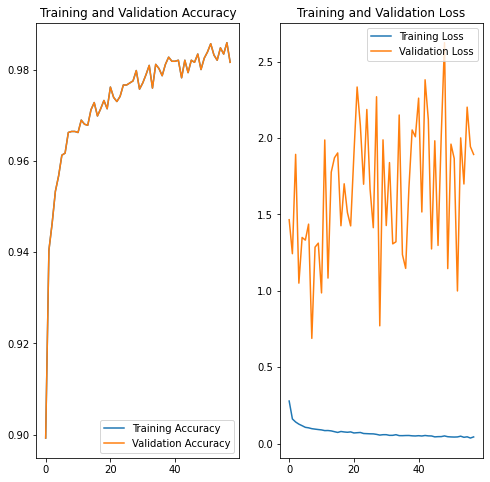

In [40]:
plot_probabilistic_training_history()

## setup server settings

In [41]:
data_dir = DATASET_PATH
# clean_up_data_dir(data_dir)        
mgx_api_access_token = "T3SHaywV1HOOhYg1GkPbVDy2dX1oqn6_"
mgx_api_url = "https://mgx-api.karamokoisrael.tech"
mgx_models_folder_id = "c2eef2be-c7fa-47b3-95a1-f40f1cc513d3"
headers = {"Authorization": 'Bearer '+mgx_api_access_token}

## Backup project

In [42]:
@tf.function
def decode_img_bytes(img):
    img = tf.strings.regex_replace(img, "\+", "-")
    img = tf.strings.regex_replace(img, "\/", "_")
    image = tf.image.decode_jpeg(tf.io.decode_base64(img), channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # 0-1
    image = tf.image.resize(images=image, size=dimensions)
    return image

In [43]:
import base64

class ExportModel(tf.keras.Model):
    def __init__(self, model, model_configs):
        super().__init__(self)       
        self.model = model
        self.model_configs = model_configs

    @tf.function(input_signature=[
        tf.TensorSpec(shape=(None,), dtype=tf.string, name="base64")
    ])
    
    def serving_fn(self, base64):
        #a = np.array([x.lower() if isinstance(x, str) else x for x in arr])
        base64_image = tf.map_fn(lambda x: decode_img_bytes(x), base64, fn_output_signature=tf.float32)
        scores = self.model.call(base64_image)                
        labels = tf.constant([self.model_configs["class_names"]]) 
        return {
            'scores': scores,
            'classes': tf.repeat(labels, repeats=tf.shape(scores)[0], axis=0, name=None),
#             'prediction_threshold': tf.constant(self.model_configs["prediction_threshold"]),
#             "sensitive_class_indexes": tf.constant(self.model_configs["sensitive_class_indexes"])
        }

    def save(self, export_path):
        sigs = {
            'serving_default' : self.serving_fn
        }
        
        
        #tf.keras.backend.set_learning_phase(0) # inference only
        tf.saved_model.save(self, export_path, signatures=sigs)

In [44]:
for model_name in [*MODELS]:
    model_data = MODELS[model_name]
    try:
        file_path = "{0}/{1}/{2}.h5".format(MODEL_PATH, SESSION_ID, model_name)
        print("backup => ", model_name)
        model_data["model"].save(file_path)
        sm = ExportModel(model_data["model"], model_data["configs"])
        sm.save(file_path.replace(".h5", ""))
        serving_file_path = file_path.replace(".h5", "")+".zip"
        shutil.make_archive(file_path.replace(".h5", ""), 'zip', file_path.replace(".h5", ""))
        
        local_file = FileLink(serving_file_path, result_html_prefix="Click here to download model({0}/{1}) ".format(SESSION_ID, model_name))
        display(local_file)
        local_file = FileLink(file_path, result_html_prefix="Click here to download model({0}/{1}) ".format(SESSION_ID, model_name))
        display(local_file)
        
        payload = {'title': model_name+"_"+SESSION_ID, "folder": mgx_models_folder_id}
        file=serving_file_path
        files = {'file': (os.path.basename(file), open(file, 'rb'), 'application/octet-stream')}
        r = requests.post(mgx_api_url+"/files", files=files, data=payload, headers=headers)
        
        file=file_path
        files = {'file': (os.path.basename(file), open(file, 'rb'), 'application/octet-stream')}
        r = requests.post(mgx_api_url+"/files", files=files, data=payload, headers=headers)      
    except Exception as e:
        print(e)

backup =>  nsfw_detector


/kaggle/working/models/1680775835_274411/nsfw_detector.zip

/kaggle/working/models/1680775835_274411/nsfw_detector.h5

In [45]:
!ls models

1680775835_274411  epoch


In [46]:
# !rm -r models/*

## Restore project

In [47]:
MODEL_PATH = "models"
session_id = "1664541550_729922"
!mkdir $MODEL_PATH/$session_id

# !rm -r $MODEL_PATH/$session_id/*
!
for model_config in models_config:
    try:
        model_path = "{0}/{1}/{2}.h5".format(MODEL_PATH, session_id, model_config["name"])
        open(model_path, 'wb').write(r.content)
        model = tf.keras.models.load_model(
              model_path, 
#               custom_objects={'KerasLayer': hub.KerasLayer} 
        )
      
        MODELS[model_config["name"]] = {
            "configs": model_config,
            "model": model,
            "session_id": session_id
        }
    except Exception as e:
        print(e)

SavedModel file does not exist at: models/1664541550_729922/nsfw_detector.h5/{saved_model.pbtxt|saved_model.pb}


### image prediction on model sequence

In [48]:
model_config = models_config[0]

In [49]:
def sequence_predict_raw(image_array):
    predictions = {}
    raw_predictions = []
    to_print = ""
    for model_name in MODELS.keys():
        model_data = MODELS[model_name]
        model = model_data["model"]
        prediction = model.predict(image_array)
        raw_predictions.append({
            "prediction": prediction,
            "model_config": model_data["configs"]
        })
        
        if(len(prediction[0]) < 3):
            class_name = model_data["configs"]["base_class"]
            predictions[class_name] = prediction[0][0]
            try:
                prob_str = str(prediction[0][0]*100)[0:5]
            except Exception as wrong: 
                  prob_str = str(prediction[0][0]*100)
            to_print  += "{0} => {1}%; \n".format(class_name, prob_str)
        else:
            to_print+= "{}: \n".format(model_data["configs"]["name"])
            for i in range(0, len(prediction[0])):
                try:
                    prob_str = str(prediction[0][i]*100)[0:5]
                except Exception as wrong: 
                    prob_str = str(prediction[0][i]*100)
                    
                to_print  += "    {0} => {1}%; \n".format(model_data["configs"]["classes"][i], prob_str)
    return to_print, predictions, raw_predictions

def secure_user_view(image, raw_predictions):
    total = len(raw_predictions[0]["prediction"][0])
    model_config = raw_predictions[0]["model_config"]
    if model_config["blur_sensitive_class"]:
        for i in range(0, total):   
            if i in model_config["sensitive_class_indexes"] and raw_predictions[0]["prediction"][0][i] > model_config["prediction_threshold"]:
                image = cv2.blur(image, model_config["blur_ksize"])
                break
    return Image.fromarray(image)

In [50]:
urls = ["http://41.media.tumblr.com/e86aa471895a8b207e55158d3d2c72c7/tumblr_nj5zxiwMi61rti48uo1_1280.jpg", "http://i.imgur.com/3oNaAqX.jpg"]
sequence_bulk_prediction_from_url(urls)

Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [51]:
main_urls = [
    "https://raw.githubusercontent.com/alex000kim/nsfw_data_scraper/main/raw_data/neutral/urls_neutral.txt",
    "https://raw.githubusercontent.com/EBazarov/nsfw_data_source_urls/master/raw_data/appearance_clothing_dresses/urls_appearance_clothing_dresses.txt"
]
total = 0
count = 0
all_urls = []
for main_url in main_urls:
    r = requests.get(main_url)
    urls = r.text.split("\n")
    print("{0} from {1} to {2}".format(count+1, total+1, total+1+len(urls)))
    total = total+1+len(urls)
    all_urls+=urls
    count+=1
    
sequence_bulk_prediction_from_url(all_urls)

1 from 1 to 36839
2 from 36840 to 41201


Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [52]:
main_urls = [
    "https://raw.githubusercontent.com/EBazarov/nsfw_data_source_urls/master/raw_data/appearance_clothing/urls_appearance_clothing.txt",
    "https://raw.githubusercontent.com/EBazarov/nsfw_data_source_urls/master/raw_data/appearance_clothing_bodyparts-through-clothes/urls_appearance_clothing_bodyparts-through-clothes.txt",
    "https://raw.githubusercontent.com/EBazarov/nsfw_data_source_urls/master/raw_data/body-parts_head_hair/urls_body-parts_head_hair.txt"    
]
total = 0
count = 0
all_urls = []
for main_url in main_urls:
    r = requests.get(main_url)
    urls = r.text.split("\n")
    print("{0} from {1} to {2}".format(count+1, total+1, total+1+len(urls)))
    total = total+1+len(urls)
    all_urls+=urls
    count+=1
    
sequence_bulk_prediction_from_url(all_urls)

1 from 1 to 24926
2 from 24927 to 31619
3 from 31620 to 33418


Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [53]:
main_urls = [
    "https://cdn8.nu-bay.com/t/170/744279_mom_bigass_family_07.jpg"
]
total = 0
count = 0
all_urls = []
for main_url in main_urls:
    r = requests.get(main_url)
    urls = r.text.split("\n")
    print("{0} from {1} to {2}".format(count+1, total+1, total+1+len(urls)))
    total = total+1+len(urls)
    all_urls+=urls
    count+=1
    
sequence_bulk_prediction_from_url(all_urls)

1 from 1 to 67


Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [54]:
sequence_predict_from_path(DATASET_PATH)

rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_not_nsfw_not_suggestive/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/female_nudity/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/male_underwear/..'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/.'
rm: refusing to remove '.' or '..' directory: skipping '/kaggle/input/nsfw-content-moderation/images/general_suggestive/..'
rm: 

Textarea(value='0', description='index', placeholder='current index goes here')

Button(description='Current', style=ButtonStyle())

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [55]:
sequence_predict_at_random()

Button(description='Again', style=ButtonStyle())

Output()

In [56]:
category = "woman"
# https://loremflickr.com
# https://lorempixel.com

In [57]:
sequence_predict_at_random("https://source.unsplash.com/category/{0}".format(category))

Button(description='Again', style=ButtonStyle())

Output()

In [58]:
# unsplash collections => https://unsplash.com/s/collections/people
collections = [
    "8909560",
    "1242151", #https://unsplash.com/collections/1242151/sexy
    "1785701",
    "8991200", #https://unsplash.com/collections/8991200/sexy
    "5052004"
]

In [59]:
sequence_predict_at_random("https://source.unsplash.com/collection/{}".format(collections[0]))

Button(description='Again', style=ButtonStyle())

Output()

In [60]:
sequence_predict_at_random("https://source.unsplash.com/collection/{}".format(collections[randrange(len(collections)-1)]))

Button(description='Again', style=ButtonStyle())

Output()

### main processing functions

In [61]:
from IPython.display import clear_output, display

import ipywidgets

import cv2

def local_video_preprocess(src, wait_time=0.1):
    stream = None
#     if "http" in src:
#         stream = CamGear(source=src, stream_mode = False, logging=True).start() # YouTube Video URL as input
        
    video = cv2.VideoCapture(src)
    
    display_handle=display(None, display_id=True)

    image_widget = ipywidgets.Image(format='jpeg')

    while True:

        try:
            clear_output(wait=True)
            if "http" in src:
#                 frame = stream.read()
                _, frame = video.read()
            else:
                _, frame = video.read()
                
            if frame is None:
                video.release()
                break
            lines, columns, _ =  frame.shape
            frame = cv2.resize(frame, (int(columns/1.5), int(lines/1.5))) 
            image_widget.value = cv2.imencode('.jpeg', frame)[1].tobytes()
            imageRGB = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(imageRGB, dimensions, interpolation = cv2.INTER_AREA)/255
            to_print, predictions, raw_predictions = sequence_predict_raw(np.array([image_resized]))
            print(to_print)
#             print(secure_user_view(image_resized, raw_predictions))
            display(image_widget)
            time.sleep(wait_time)
        except KeyboardInterrupt:
            video.release()
            break

### Local video preprocessing

In [62]:
url = "https://instagram.fabj4-1.fna.fbcdn.net/v/t50.16885-16/10000000_2212202748956557_6988754337939055544_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5pZ3R2LmJhc2VsaW5lIiwicWVfZ3JvdXBzIjoiW1wiaWdfd2ViX2RlbGl2ZXJ5X3Z0c19vdGZcIl0ifQ&_nc_ht=instagram.fabj4-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=GR3CTwAaW4MAX8hWAL7&edm=ALQROFkBAAAA&vs=369312178565606_3600404313&_nc_vs=HBksFQAYJEdJQ1dtQUNOendXWC1Oc0hBTGpqVTljS0MtMWdidlZCQUFBRhUAAsgBABUAGCRHTW9TMUJDS3RrckhvdU1IQUxBWDg5VmtuUUJfYnZWQkFBQUYVAgLIAQAoABgAGwGIB3VzZV9vaWwBMRUAACbw4KHu2N%2BGQBUCKAJDMywXQEzu2RaHKwIYEmRhc2hfYmFzZWxpbmVfMV92MREAdewHAA%3D%3D&ccb=7-5&oe=62A1DE63&oh=00_AT-JVw8vpSzcLyFKhdjgiMqGOKtR9FbOhBJwGeC_Occytw&_nc_sid=30a2ef"
local_video_preprocess(url, 0.5)

[tcp @ 0x5cbbcade0dc0] Failed to resolve hostname instagram.fabj4-1.fna.fbcdn.net: Name or service not known
[ERROR:0] global /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap_images.cpp:235: error: (-5:Bad argument) CAP_IMAGES: error, expected '0?[1-9][du]' pattern, got: https://instagram.fabj4-1.fna.fbcdn.net/v/t50.16885-16/10000000_2212202748956557_6988754337939055544_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5pZ3R2LmJhc2VsaW5lIiwicWVfZ3JvdXBzIjoiW1wiaWdfd2ViX2RlbGl2ZXJ5X3Z0c19vdGZcIl0ifQ&_nc_ht=instagram.fabj4-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=GR3CTwAaW4MAX8hWAL7&edm=ALQROFkBAAAA&vs=369312178565606_3600404313&_nc_vs=HBksFQAYJEdJQ1dtQUNOendXWC1Oc0hBTGpqVTljS0MtMWdidlZCQUFBRhUAAsgBABUAGCRHTW9TMUJDS3RrckhvdU1IQUxBWDg5VmtuUUJfYnZWQkFBQUYVAgLIAQAoABgAGwGIB3VzZV9vaWwBMRUAACbw4KHu2N%2BGQBUCKAJDMywXQEzu2RaHKwIYEmRhc2hfYmFzZWxpbmVfMV9

None

In [63]:
video_links = [
    "https://instagram.fabj4-1.fna.fbcdn.net/v/t50.2886-16/277264867_308902054518062_7041975200412646161_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5jbGlwcy5iYXNlbGluZSIsInFlX2dyb3VwcyI6IltcImlnX3dlYl9kZWxpdmVyeV92dHNfb3RmXCJdIn0&_nc_ht=instagram.fabj4-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=nHW3_OTPaCsAX_V9dQ1&edm=ALQROFkBAAAA&vs=479413740502820_3851548042&_nc_vs=HBksFQAYJEdPTzVoaEF1M1RyZDhSZ0JBQkc3dElFaUg3cGhicV9FQUFBRhUAAsgBABUAGCRHRjMtaGhDNkNFbFdaMmdCQU56V05wcXhTT1luYnFfRUFBQUYVAgLIAQAoABgAGwAVAAAm7tD6p8%2B1tj8VAigCQzMsF0A%2BAAAAAAAAGBJkYXNoX2Jhc2VsaW5lXzFfdjERAHX%2BBwA%3D&ccb=7-5&oe=62A22036&oh=00_AT_CbmMIL3FkQXCvCUidfaWN6phH6nzegw3XKQgUk7N5bA&_nc_sid=30a2ef"
]

In [64]:
local_video_preprocess(video_links[len(video_links)-1], 0.5)

[tcp @ 0x5cbbcbd41a00] Failed to resolve hostname instagram.fabj4-1.fna.fbcdn.net: Name or service not known
[ERROR:0] global /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap_images.cpp:235: error: (-5:Bad argument) CAP_IMAGES: error, expected '0?[1-9][du]' pattern, got: https://instagram.fabj4-1.fna.fbcdn.net/v/t50.2886-16/277264867_308902054518062_7041975200412646161_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5jbGlwcy5iYXNlbGluZSIsInFlX2dyb3VwcyI6IltcImlnX3dlYl9kZWxpdmVyeV92dHNfb3RmXCJdIn0&_nc_ht=instagram.fabj4-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=nHW3_OTPaCsAX_V9dQ1&edm=ALQROFkBAAAA&vs=479413740502820_3851548042&_nc_vs=HBksFQAYJEdPTzVoaEF1M1RyZDhSZ0JBQkc3dElFaUg3cGhicV9FQUFBRhUAAsgBABUAGCRHRjMtaGhDNkNFbFdaMmdCQU56V05wcXhTT1luYnFfRUFBQUYVAgLIAQAoABgAGwAVAAAm7tD6p8%2B1tj8VAigCQzMsF0A%2BAAAAAAAAGBJkYXNoX2Jhc2VsaW5lXzFfdjERAHX%2BBwA

None

In [65]:
for video_link in video_links:
    try:
        local_video_preprocess(video_link)
        break
    except Exception as wrong: 
        pass

[tcp @ 0x5cbbcbd41a00] Failed to resolve hostname instagram.fabj4-1.fna.fbcdn.net: Name or service not known


None

[ERROR:0] global /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/videoio/src/cap_images.cpp:235: error: (-5:Bad argument) CAP_IMAGES: error, expected '0?[1-9][du]' pattern, got: https://instagram.fabj4-1.fna.fbcdn.net/v/t50.2886-16/277264867_308902054518062_7041975200412646161_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5jbGlwcy5iYXNlbGluZSIsInFlX2dyb3VwcyI6IltcImlnX3dlYl9kZWxpdmVyeV92dHNfb3RmXCJdIn0&_nc_ht=instagram.fabj4-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=nHW3_OTPaCsAX_V9dQ1&edm=ALQROFkBAAAA&vs=479413740502820_3851548042&_nc_vs=HBksFQAYJEdPTzVoaEF1M1RyZDhSZ0JBQkc3dElFaUg3cGhicV9FQUFBRhUAAsgBABUAGCRHRjMtaGhDNkNFbFdaMmdCQU56V05wcXhTT1luYnFfRUFBQUYVAgLIAQAoABgAGwAVAAAm7tD6p8%2B1tj8VAigCQzMsF0A%2BAAAAAAAAGBJkYXNoX2Jhc2VsaW5lXzFfdjERAHX%2BBwA%3D&ccb=7-5&oe=62A22036&oh=00_AT_CbmMIL3FkQXCvCUidfaWN6phH6nzegw3XKQgUk7N5bA&_nc_sid=30a2ef in function 'icvE

In [66]:
!ls

__notebook__.ipynb  assets  image_dataset.csv  models  save  test


In [67]:
local_video_preprocess("sex-3.mp4", 0.3)

None

In [68]:
prepared_data = {
    "test":{
        "local_prep_start": 1,
        "local_prep_end": 35,
        "base_name": "test-"
    },
    "sex-trip":{
        "local_prep_start": 1,
        "local_prep_end": 35,
        "base_name": "sex-trip-"
    },
    "porn":{
        "local_prep_start": 1,
        "local_prep_end": 3,
        "base_name": "porn-"
    },
    "sex":{
        "local_prep_start": 1,
        "local_prep_end": 5,
        "base_name": "sex-"
    },
    "normal":{
        "local_prep_start": 1,
        "local_prep_end": 7,
        "base_name": "normal-"
    },
    "normal-sexy":{
        "local_prep_start": 1,
        "local_prep_end": 10,
        "base_name": "normal-sexy-"
    },
    "sexy-woman":{
        "local_prep_start": 1,
        "local_prep_end": 13,
        "base_name": "sexy-woman-"
    }
}

In [69]:
for key in prepared_data.keys():
    base_name = prepared_data[key]["base_name"]
    local_prep_start = prepared_data[key]["local_prep_start"]
    local_prep_end = prepared_data[key]["local_prep_end"]
    for i in range(local_prep_start-1, local_prep_end-1):
        try:
            local_video_preprocess("assets/{0}{1}.mp4".format(base_name, i))
        except Exception as wrong: 
            continue

None

In [70]:
import tensorflow as tf

In [71]:
tf.__version__

'2.6.2'

In [72]:
!pip freeze

absl-py==0.15.0
access==1.1.3
affine==2.3.0
aiobotocore==2.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1637087016127/work
aioitertools==0.9.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.1.0
alembic==1.7.6
allennlp==2.9.0
altair==4.2.0
annoy==1.17.0
ansiwrap==0.8.4
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1637703203932/work/dist
apache-beam==2.34.0
aplus==0.11.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argcomplete @ file:///home/conda/feedstock_root/build_artifacts/argcomplete_1619128689661/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1636021379047/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1635261338479/work
arviz==0.11.4
asgiref==3.5.0
asn1crypto @ file:///home/conda/feedstock_root/build_artifacts/asn1crypto_1595949944546/work
astropy==4.3.1
astunparse==1.6.3
async